In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
X_train = pd.read_csv('data/X_train_update.csv', index_col=0)
X_test = pd.read_csv('data/X_test_update.csv', index_col=0)
y_train = pd.read_csv('data/Y_train_CVw08PX.csv', index_col=0)

# Merge train data
train_data = X_train.join(y_train)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of categories: {train_data['prdtypecode'].nunique()}")

Training samples: 84916
Test samples: 13812
Number of categories: 27


In [3]:
# Display basic info
print("=== TRAIN DATA INFO ===")
print(train_data.info())
print("\n=== COLUMNS ===")
print(train_data.columns.tolist())

# Show first few rows
print("\n=== FIRST 5 ROWS ===")
display(train_data.head())

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(f"Total rows: {len(train_data)}")
print(f"Columns: {train_data.shape[1]}")
print(f"Missing values in description: {train_data['description'].isna().sum()} ({train_data['description'].isna().sum()/len(train_data)*100:.1f}%)")
print(f"Missing values in designation: {train_data['designation'].isna().sum()}")

=== TRAIN DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB
None

=== COLUMNS ===
['designation', 'description', 'productid', 'imageid', 'prdtypecode']

=== FIRST 5 ROWS ===


,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705



=== BASIC STATISTICS ===
Total rows: 84916
Columns: 5
Missing values in description: 29800 (35.1%)
Missing values in designation: 0


Duplicate rows: 0
Duplicate designations: 2651
Duplicate descriptions (non-null): 7610
Products with same designation/description pairs: 2366


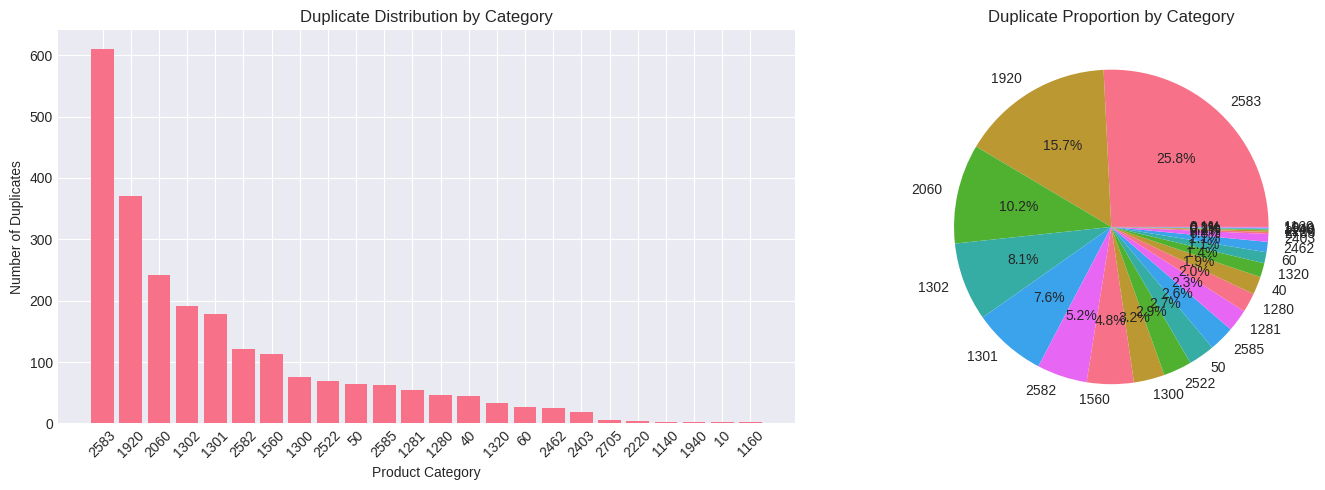

In [4]:
# Check for duplicate rows
duplicate_rows = train_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

# Check duplicates in individual columns
duplicate_designation = train_data['designation'].duplicated().sum()
duplicate_description = train_data['description'].dropna().duplicated().sum()

print(f"Duplicate designations: {duplicate_designation}")
print(f"Duplicate descriptions (non-null): {duplicate_description}")

# Check for products with same designation/description but different IDs
train_data['designation_description'] = train_data['designation'].fillna('') + '|' + train_data['description'].fillna('')
duplicate_pairs = train_data[train_data.duplicated(subset=['designation_description'], keep=False)]
print(f"Products with same designation/description pairs: {len(duplicate_pairs)}")

# Visualize duplicate distribution by category
if len(duplicate_pairs) > 0:
    dup_by_category = duplicate_pairs['prdtypecode'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart
    axes[0].bar(dup_by_category.index.astype(str), dup_by_category.values)
    axes[0].set_xlabel('Product Category')
    axes[0].set_ylabel('Number of Duplicates')
    axes[0].set_title('Duplicate Distribution by Category')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Pie chart
    axes[1].pie(dup_by_category.values, labels=dup_by_category.index.astype(str), autopct='%1.1f%%')
    axes[1].set_title('Duplicate Proportion by Category')
    
    plt.tight_layout()
    plt.show()

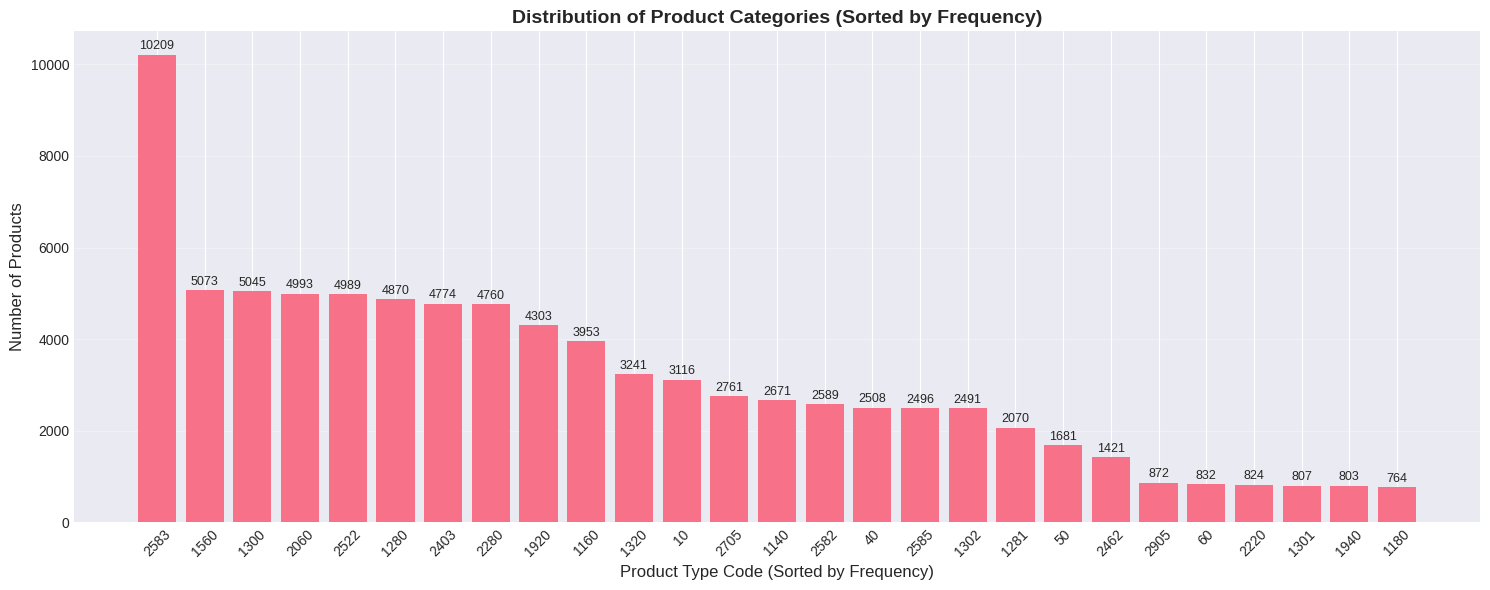

=== CATEGORY DISTRIBUTION STATISTICS ===
Total categories: 27
Most frequent category: 2583 with 10209 samples
Least frequent category: 1180 with 764 samples
Imbalance ratio: 13.4:1

Top 5 categories by count:
  Category 2583: 10209 samples (12.0%)
  Category 1560: 5073 samples (6.0%)
  Category 1300: 5045 samples (5.9%)
  Category 2060: 4993 samples (5.9%)
  Category 2522: 4989 samples (5.9%)

Bottom 5 categories by count:
  Category 60: 832 samples (1.0%)
  Category 2220: 824 samples (1.0%)
  Category 1301: 807 samples (1.0%)
  Category 1940: 803 samples (0.9%)
  Category 1180: 764 samples (0.9%)


In [5]:
# Analyze category distribution - SORT BY FREQUENCY, not index
category_counts_sorted = train_data['prdtypecode'].value_counts()  # Already sorted by frequency descending

# Plot - keep sorted by frequency for better visualization
plt.figure(figsize=(15, 6))
bars = plt.bar(category_counts_sorted.index.astype(str), category_counts_sorted.values)
plt.xlabel('Product Type Code (Sorted by Frequency)', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.title('Distribution of Product Categories (Sorted by Frequency)', fontsize=14, fontweight='bold')

# Add count labels on top of bars
for bar, count in zip(bars, category_counts_sorted.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(count), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate imbalance statistics - Use the frequency-sorted version
print("=== CATEGORY DISTRIBUTION STATISTICS ===")
print(f"Total categories: {len(category_counts_sorted)}")
print(f"Most frequent category: {category_counts_sorted.index[0]} with {category_counts_sorted.iloc[0]} samples")
print(f"Least frequent category: {category_counts_sorted.index[-1]} with {category_counts_sorted.iloc[-1]} samples")
print(f"Imbalance ratio: {category_counts_sorted.iloc[0]/category_counts_sorted.iloc[-1]:.1f}:1")

# Show top and bottom categories CORRECTLY
print("\nTop 5 categories by count:")
for i in range(5):
    code = category_counts_sorted.index[i]
    count = category_counts_sorted.iloc[i]
    print(f"  Category {code}: {count} samples ({(count/len(train_data)*100):.1f}%)")

print("\nBottom 5 categories by count:")
for i in range(-5, 0):  # Last 5 indices
    code = category_counts_sorted.index[i]
    count = category_counts_sorted.iloc[i]
    print(f"  Category {code}: {count} samples ({(count/len(train_data)*100):.1f}%)")

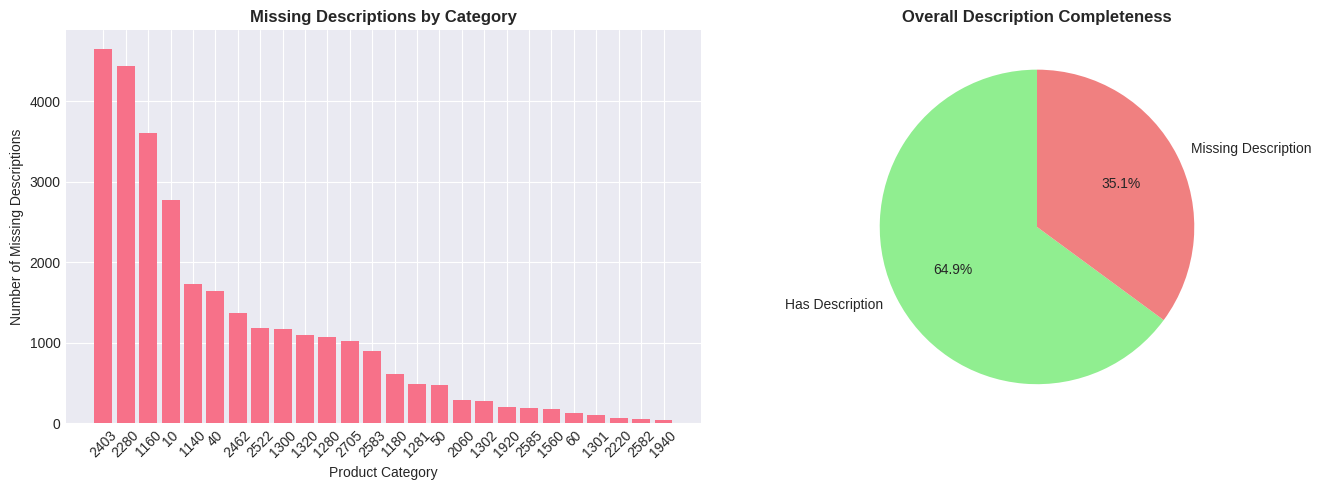


Created combined_text field (designation + description)
Empty combined texts: 0


In [6]:
# Analyze missing descriptions
missing_desc = train_data['description'].isna()
missing_by_category = train_data[missing_desc]['prdtypecode'].value_counts()

plt.figure(figsize=(14, 5))

# Bar chart of missing descriptions by category
plt.subplot(1, 2, 1)
plt.bar(missing_by_category.index.astype(str), missing_by_category.values)
plt.xlabel('Product Category')
plt.ylabel('Number of Missing Descriptions')
plt.title('Missing Descriptions by Category', fontweight='bold')
plt.xticks(rotation=45)

# Pie chart of missing vs non-missing
plt.subplot(1, 2, 2)
labels = ['Has Description', 'Missing Description']
sizes = [len(train_data) - missing_desc.sum(), missing_desc.sum()]
colors = ['lightgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Overall Description Completeness', fontweight='bold')

plt.tight_layout()
plt.show()

# Create combined text field as suggested
train_data['combined_text'] = train_data['designation'].fillna('') + ' ' + train_data['description'].fillna('')
print(f"\nCreated combined_text field (designation + description)")
print(f"Empty combined texts: {(train_data['combined_text'].str.strip() == '').sum()}")

=== HTML CONTENT ANALYSIS ===
     Column  Total Rows  With HTML  Percentage
Designation       84916        163    0.191954
Description       84916      18037   21.240991


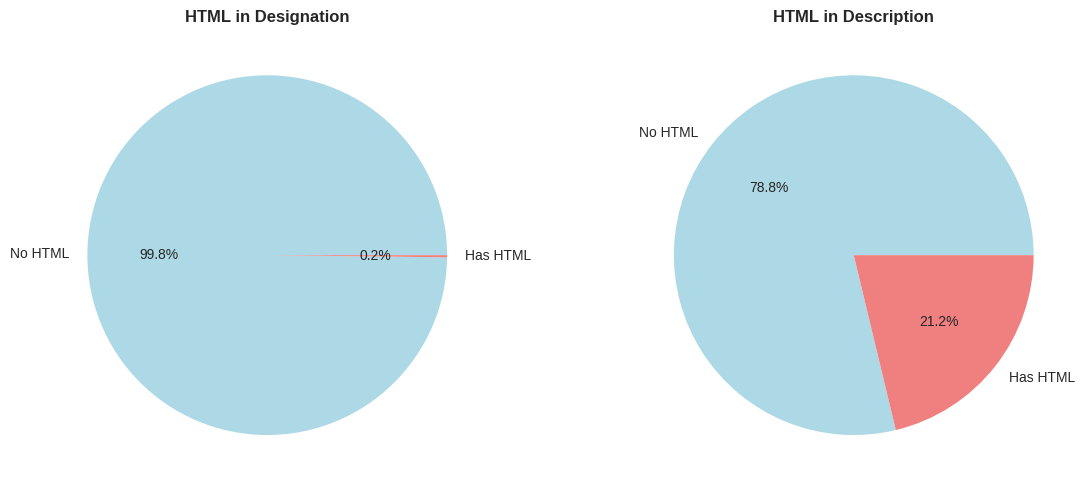


Cleaning HTML from text columns...

=== HTML CLEANING EXAMPLES ===

Original description (sample): PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautem...
Cleaned description: PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ...

Original description (sample): Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous...
Cleaned description: Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans......

Original description (

In [7]:
import html

def contains_html(text):
    """Check if text contains HTML tags"""
    if pd.isna(text):
        return False
    # Simple regex to detect HTML tags
    html_pattern = re.compile(r'<[^>]+>|&[a-z]+;')
    return bool(html_pattern.search(str(text)))

def clean_html(text):
    """Remove HTML tags and decode HTML entities"""
    if pd.isna(text):
        return text
    
    # Decode HTML entities
    text = html.unescape(str(text))
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Clean up extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Check HTML in designation and description
train_data['has_html_designation'] = train_data['designation'].apply(contains_html)
train_data['has_html_description'] = train_data['description'].apply(contains_html)

html_stats = pd.DataFrame({
    'Column': ['Designation', 'Description'],
    'Total Rows': [len(train_data), len(train_data)],
    'With HTML': [train_data['has_html_designation'].sum(), train_data['has_html_description'].sum()],
    'Percentage': [
        train_data['has_html_designation'].sum()/len(train_data)*100,
        train_data['has_html_description'].sum()/len(train_data)*100
    ]
})

print("=== HTML CONTENT ANALYSIS ===")
print(html_stats.to_string(index=False))

# Visualize HTML presence
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Designation HTML
designation_counts = train_data['has_html_designation'].value_counts()
axes[0].pie(designation_counts.values, labels=['No HTML', 'Has HTML'], 
           autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[0].set_title('HTML in Designation', fontweight='bold')

# Description HTML
description_counts = train_data['has_html_description'].value_counts()
axes[1].pie(description_counts.values, labels=['No HTML', 'Has HTML'], 
           autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
axes[1].set_title('HTML in Description', fontweight='bold')

plt.tight_layout()
plt.show()

# Clean the text columns
print("\nCleaning HTML from text columns...")
train_data['designation_clean'] = train_data['designation'].apply(clean_html)
train_data['description_clean'] = train_data['description'].apply(clean_html)
train_data['combined_text_clean'] = train_data['designation_clean'] + ' ' + train_data['description_clean'].fillna('')

# Show examples
print("\n=== HTML CLEANING EXAMPLES ===")
html_samples = train_data[train_data['has_html_description']].head(3)
for idx, row in html_samples.iterrows():
    print(f"\nOriginal description (sample): {str(row['description'])[:200]}...")
    print(f"Cleaned description: {row['description_clean'][:200]}...")

In [ ]:
from langdetect import detect, DetectorFactory, LangDetectException

# Set seed for reproducibility
DetectorFactory.seed = 42

def detect_language_safe(text):
    """Safely detect language of text"""
    if pd.isna(text) or str(text).strip() == '':
        return 'unknown'
    
    text_str = str(text)
    
    # Take only first 500 chars for efficiency
    sample = text_str[:500] if len(text_str) > 500 else text_str
    
    try:
        return detect(sample)
    except LangDetectException:
        return 'unknown'
    except:
        return 'error'

# Sample for language detection (for efficiency)
sample_size = min(2000, len(train_data))
sample_indices = np.random.choice(train_data.index, sample_size, replace=False)
sample_data = train_data.loc[sample_indices]

print(f"Detecting languages on sample of {sample_size} texts...")
sample_data['detected_lang'] = sample_data['combined_text_clean'].apply(detect_language_safe)

# Language distribution
lang_distribution = sample_data['detected_lang'].value_counts()
print("\n=== LANGUAGE DISTRIBUTION ===")
print(lang_distribution.head(10))

# Visualization
plt.figure(figsize=(12, 5))

# Bar chart for top languages
plt.subplot(1, 2, 1)
top_langs = lang_distribution.head(10)
plt.bar(top_langs.index, top_langs.values)
plt.xlabel('Language Code')
plt.ylabel('Count')
plt.title(f'Top 10 Languages (Sample of {sample_size})', fontweight='bold')
plt.xticks(rotation=45)

# Pie chart for language proportion
plt.subplot(1, 2, 2)
# Group less frequent languages as 'Other'
top_n = 5
top_langs_pie = lang_distribution.head(top_n)
other_count = lang_distribution[top_n:].sum()
pie_data = pd.concat([top_langs_pie, pd.Series([other_count], index=['Other'])])
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

# Language by category (for top 5 categories)
top_categories = train_data['prdtypecode'].value_counts().head(5).index.tolist()
category_lang_data = []

for category in top_categories:
    category_sample = train_data[train_data['prdtypecode'] == category].sample(
        min(100, len(train_data[train_data['prdtypecode'] == category])), 
        random_state=42
    )
    langs = category_sample['combined_text_clean'].apply(detect_language_safe)
    lang_counts = langs.value_counts()
    category_lang_data.append({
        'category': category,
        'fr_percentage': lang_counts.get('fr', 0) / len(category_sample) * 100,
        'en_percentage': lang_counts.get('en', 0) / len(category_sample) * 100,
        'de_percentage': lang_counts.get('de', 0) / len(category_sample) * 100,
        'other_percentage': 100 - (lang_counts.get('fr', 0) + lang_counts.get('en', 0) + lang_counts.get('de', 0)) / len(category_sample) * 100
    })

lang_by_category_df = pd.DataFrame(category_lang_data)
lang_by_category_df.set_index('category', inplace=True)

# Stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
lang_by_category_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Product Category')
ax.set_ylabel('Percentage (%)')
ax.set_title('Language Distribution in Top 5 Categories', fontweight='bold')
ax.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== LANGUAGE DECISION ===")
print("Based on analysis:")
print(f"- French texts: {lang_distribution.get('fr', 0)/sample_size*100:.1f}%")
print(f"- English texts: {lang_distribution.get('en', 0)/sample_size*100:.1f}%")
print(f"- German texts: {lang_distribution.get('de', 0)/sample_size*100:.1f}%")
print("\nDecision: We'll translate non-French texts to French for consistency.")

Detecting languages on sample of 2000 texts...


In [ ]:
print("=" * 70)
print("8. Word Frequency Analysis (3.8)")
print("=" * 70)

import re
from collections import Counter
from wordcloud import WordCloud
import nltk

# Download NLTK stopwords if needed
try:
    nltk.data.find('corpora/stopwords')
    print("✓ NLTK stopwords already available")
except:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')

# Get French and English stopwords from NLTK
french_stopwords = set(nltk.corpus.stopwords.words('french'))
english_stopwords = set(nltk.corpus.stopwords.words('english'))
combined_stopwords = french_stopwords.union(english_stopwords)

def extract_words_safe(text, remove_stopwords=True):
    """
    Safe word extraction with memory optimization
    """
    if pd.isna(text) or str(text).strip() == '':
        return []
    
    # Use regex to find all alphanumeric sequences
    words = re.findall(r'\w+', str(text).lower())
    
    # Filter words: remove stopwords, digits, short words (<3)
    if remove_stopwords:
        filtered_words = [word for word in words 
                         if (word not in combined_stopwords and 
                             not word.isdigit() and 
                             len(word) > 2)]
    else:
        filtered_words = [word for word in words 
                         if (not word.isdigit() and len(word) > 2)]
    
    return filtered_words

# Extract words from designation and combined text (with progress)
print("\nExtracting words from text columns...")
# Process in chunks to avoid memory issues
chunk_size = 5000
designation_words_chunks = []
text_words_chunks = []

total_chunks = len(train_data) // chunk_size + 1
for i in range(0, len(train_data), chunk_size):
    chunk = train_data.iloc[i:i+chunk_size]
    designation_words_chunks.extend([word for sublist in 
                                    chunk['designation_clean'].apply(extract_words_safe) 
                                    for word in sublist])
    text_words_chunks.extend([word for sublist in 
                             chunk['combined_text_clean'].apply(extract_words_safe) 
                             for word in sublist])
    print(f"  Processed {min(i+chunk_size, len(train_data))}/{len(train_data)} rows")

# Calculate word frequencies
designation_freq = Counter(designation_words_chunks)
text_freq = Counter(text_words_chunks)

print(f"\n✓ Total unique words in designation: {len(designation_freq):,}")
print(f"✓ Total unique words in combined text: {len(text_freq):,}")

# Get top 20 words for visualization
top_designation = designation_freq.most_common(20)
top_text = text_freq.most_common(20)

# Create visualization without word clouds first
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Top words in designation - horizontal bar chart
axes[0].barh([w[0] for w in top_designation], 
             [w[1] for w in top_designation],
             color='skyblue', edgecolor='black', height=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Words in Designation', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# 2. Top words in text - horizontal bar chart
axes[1].barh([w[0] for w in top_text], 
             [w[1] for w in top_text],
             color='lightcoral', edgecolor='black', height=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Words in Combined Text', fontweight='bold', fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Display top words comparison
print("\n" + "="*60)
print("TOP 10 WORDS COMPARISON")
print("="*60)
print(f"{'Designation':<20} | {'Combined Text':<20}")
print("-"*60)
for i in range(10):
    des_word, des_freq = top_designation[i]
    txt_word, txt_freq = top_text[i]
    print(f"{des_word:<20} ({des_freq:>5}) | {txt_word:<20} ({txt_freq:>5})")

# Now generate word clouds with memory optimization
print("\n" + "="*60)
print("WORD CLOUDS (Optimized for Memory)")
print("="*60)

# Use only top 1000 words for word clouds to reduce memory usage
top_designation_words = dict(designation_freq.most_common(500))  # Top 500 only
top_text_words = dict(text_freq.most_common(500))  # Top 500 only

# Generate word clouds with smaller settings
try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Word cloud for designation
    print("Generating designation word cloud...")
    wordcloud_designation = WordCloud(
        width=400, height=200,  # Smaller dimensions
        background_color='white',
        max_words=150,  # Fewer words
        min_font_size=8,
        max_font_size=40,
        random_state=42,
        collocations=False  # Disable collocations for better performance
    ).generate_from_frequencies(top_designation_words)
    
    axes[0].imshow(wordcloud_designation, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Word Cloud: Designation (Top 500 Words)', fontweight='bold')
    
    # Word cloud for text
    print("Generating text word cloud...")
    wordcloud_text = WordCloud(
        width=400, height=200,
        background_color='white',
        max_words=150,
        min_font_size=8,
        max_font_size=40,
        random_state=42,
        collocations=False
    ).generate_from_frequencies(top_text_words)
    
    axes[1].imshow(wordcloud_text, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Word Cloud: Combined Text (Top 500 Words)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    print("✓ Word clouds generated successfully")
    
except Exception as e:
    print(f"⚠ Word cloud generation failed: {e}")
    print("  Using simplified visualization instead...")
    
    # Fallback: show top 30 words in bar charts
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 30 designation words
    top_designation_30 = designation_freq.most_common(30)
    axes[0].barh([w[0] for w in top_designation_30], 
                 [w[1] for w in top_designation_30],
                 color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Frequency')
    axes[0].set_title('Top 30 Words in Designation', fontweight='bold')
    axes[0].invert_yaxis()
    
    # Top 30 text words
    top_text_30 = text_freq.most_common(30)
    axes[1].barh([w[0] for w in top_text_30], 
                 [w[1] for w in top_text_30],
                 color='lightcoral', edgecolor='black')
    axes[1].set_xlabel('Frequency')
    axes[1].set_title('Top 30 Words in Combined Text', fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Analyze common e-commerce words
print("\n" + "="*60)
print("E-COMMERCE WORDS ANALYSIS")
print("="*60)
ecommerce_words = {
    'produit': 'product',
    'article': 'item',
    'livraison': 'delivery',
    'gratuit': 'free',
    'qualité': 'quality',
    'haute': 'high',
    'neuf': 'new',
    'occasion': 'used',
    'taille': 'size',
    'couleur': 'color'
}

print("Frequency of common e-commerce words:")
for word_fr, word_en in ecommerce_words.items():
    if word_fr in text_freq:
        print(f"  {word_fr} ({word_en}): {text_freq[word_fr]:>6} occurrences")

In [ ]:
print("\n" + "="*70)
print("9. Word Frequency by Product Type (3.9) - OPTIMIZED")
print("="*70)

# Select 4 representative categories for analysis
top_categories = train_data['prdtypecode'].value_counts().head(4).index.tolist()
print(f"Analyzing top 4 categories: {top_categories}")

# Create analysis without memory-intensive operations
category_word_data = []

for category in top_categories:
    # Get texts for this category
    category_texts = train_data[train_data['prdtypecode'] == category]['combined_text_clean']
    
    # Process in chunks
    all_words = []
    chunk_size = 1000
    for i in range(0, len(category_texts), chunk_size):
        chunk = category_texts.iloc[i:i+chunk_size]
        for text in chunk:
            all_words.extend(extract_words_safe(text, remove_stopwords=True))
    
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(10)
    
    category_word_data.append({
        'category': category,
        'top_words': top_words,
        'total_words': len(all_words),
        'unique_words': len(word_freq)
    })

# Create visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

for idx, data in enumerate(category_word_data):
    words = [w[0] for w in data['top_words']]
    freqs = [w[1] for w in data['top_words']]
    
    axes[idx].barh(words, freqs, color=f'C{idx}', edgecolor='black', height=0.7)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'Category {data["category"]} - Top 10 Words '
                       f'({data["total_words"]:,} total words)', 
                       fontweight='bold', fontsize=11)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print top words for naming suggestions
print("\n" + "="*70)
print("CATEGORY TOP WORDS FOR NAMING")
print("="*70)
for data in category_word_data:
    print(f"\nCategory {data['category']}:")
    print(f"  Total words: {data['total_words']:,}")
    print(f"  Unique words: {data['unique_words']:,}")
    print("  Top 5 words:")
    for word, freq in data['top_words'][:5]:
        print(f"    {word}: {freq}")

In [ ]:
print("\n" + "="*70)
print("10. Image Analysis (3.10) - Adjusted for Your Paths")
print("="*70)

import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Define your exact paths
IMAGE_TRAIN_PATH = "data/images/image_train"
IMAGE_TEST_PATH = "data/images/image_test"

# Check if image directories exist
print(f"Checking image directories...")
print(f"Train images path: {IMAGE_TRAIN_PATH}")
print(f"Test images path: {IMAGE_TEST_PATH}")

train_dir = Path(IMAGE_TRAIN_PATH)
if not train_dir.exists():
    print(f"❌ ERROR: Train image directory not found: {IMAGE_TRAIN_PATH}")
    print("Please check your file structure. The directory should contain .jpg files.")
else:
    # Count train images
    train_images = list(train_dir.glob("*.jpg"))
    print(f"✓ Found {len(train_images)} train images")
    
    # Show sample of image filenames
    if train_images:
        print("Sample image filenames:")
        for img in train_images[:3]:
            print(f"  - {img.name}")

# bounding box function
def find_inner_img_box(img):
    """
    Return the bounding box of inner image. This is useful
    for images that are surrounded by a big blank area
    
    Args:
        img: RGB image as an np.array
    
    Returns:
        Bounding box of inner image as a tuple (top, left, bottom, right)
        or None if image is all blank
    """
    # Check if image exists
    if img is None:
        return None
    
    # top
    for top in range(img.shape[0]):
        if (img[top] != 255).any():
            break
    
    if top == img.shape[0]-1:
        # image is all blank so return None
        return None
    
    # bottom
    for bottom in range(img.shape[0]-1, top, -1):
        if (img[bottom] != 255).any():
            break
    
    # left
    for left in range(img.shape[1]):
        if (img[top:bottom+1, left] != 255).any():
            break
    
    # right
    for right in range(img.shape[1]-1, left, -1):
        if (img[top:bottom+1, right] != 255).any():
            break
    
    return (top, left, bottom, right)

def analyze_images_for_path(image_path, sample_size=200):
    """
    Analyze images from the specified path
    """
    print(f"\nAnalyzing images from: {image_path}")
    
    # Get list of available images
    image_dir = Path(image_path)
    if not image_dir.exists():
        print(f"❌ Directory not found: {image_path}")
        return pd.DataFrame()
    
    all_images = list(image_dir.glob("*.jpg"))
    print(f"Found {len(all_images)} images")
    
    if len(all_images) == 0:
        print("❌ No images found!")
        return pd.DataFrame()
    
    # Take a sample
    sample_size = min(sample_size, len(all_images))
    sample_images = np.random.choice(all_images, sample_size, replace=False)
    
    # Initialize lists
    top_list, left_list, bottom_list, right_list = [], [], [], []
    img_width_list, img_height_list = [], []
    blank_img_list = []
    imageid_list = []
    
    print(f"Processing {sample_size} images...")
    
    for img_path in tqdm(sample_images, desc="Analyzing images"):
        try:
            # Extract imageid from filename
            filename = img_path.name
            # Expected format: image_<imageid>_product_<productid>.jpg
            parts = filename.split('_')
            if len(parts) >= 2:
                try:
                    imageid = int(parts[1])
                except:
                    imageid = 0
            else:
                imageid = 0
            
            # Read image
            img = cv2.imread(str(img_path))
            
            if img is None:
                print(f"Warning: Could not read {filename}")
                continue
            
            # Get dimensions
            height, width = img.shape[:2]
            img_width_list.append(width)
            img_height_list.append(height)
            imageid_list.append(imageid)
            
            # Find bounding box
            box = find_inner_img_box(img)
            
            if box is None:
                blank_img_list.append(True)
                top_list.append(0)
                left_list.append(0)
                bottom_list.append(height - 1)
                right_list.append(width - 1)
            else:
                blank_img_list.append(False)
                top_list.append(box[0])
                left_list.append(box[1])
                bottom_list.append(box[2])
                right_list.append(box[3])
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue
    
    # Create DataFrame
    if len(img_width_list) > 0:
        results = pd.DataFrame({
            'imageid': imageid_list,
            'imagewidth': img_width_list,
            'imageheight': img_height_list,
            'imageempty': blank_img_list,
            'innerimagetop': top_list,
            'innerimageleft': left_list,
            'innerimagebottom': bottom_list,
            'innerimageright': right_list
        })
        return results
    else:
        return pd.DataFrame()

# Analyze train images
if train_dir.exists():
    image_stats_df = analyze_images_for_path(IMAGE_TRAIN_PATH, sample_size=200)
    
    if not image_stats_df.empty:
        # Calculate inner image ratio
        image_stats_df['innerimagewidth'] = image_stats_df['innerimageright'] - image_stats_df['innerimageleft']
        image_stats_df['innerimageheight'] = image_stats_df['innerimagebottom'] - image_stats_df['innerimagetop']
        image_stats_df['innerimagewidthratio'] = image_stats_df['innerimagewidth'] / image_stats_df['imagewidth']
        image_stats_df['innerimageheightratio'] = image_stats_df['innerimageheight'] / image_stats_df['imageheight']
        image_stats_df['innerimageratio'] = np.maximum(image_stats_df['innerimagewidthratio'], 
                                                      image_stats_df['innerimageheightratio'])
        
        print(f"\n✓ Images analyzed: {len(image_stats_df)}")
        print(f"✗ Empty images: {image_stats_df['imageempty'].sum()}")
        print(f"• Average image width: {image_stats_df['imagewidth'].mean():.0f}px")
        print(f"• Average image height: {image_stats_df['imageheight'].mean():.0f}px")
        print(f"• Average inner image ratio: {image_stats_df['innerimageratio'].mean():.3f}")
        print(f"• Images with ratio < 0.8: {(image_stats_df['innerimageratio'] < 0.8).sum()} ({(image_stats_df['innerimageratio'] < 0.8).sum()/len(image_stats_df)*100:.1f}%)")
        
        # Merge with category information from train_data
        # First, let's match imageids with categories
        merged_stats = []
        for _, img_row in image_stats_df.iterrows():
            # Find matching row in train_data
            matching_rows = train_data[train_data['imageid'] == img_row['imageid']]
            if len(matching_rows) > 0:
                for _, train_row in matching_rows.iterrows():
                    merged_row = img_row.copy()
                    merged_row['prdtypecode'] = train_row['prdtypecode']
                    merged_stats.append(merged_row)
        
        if merged_stats:
            merged_df = pd.DataFrame(merged_stats)
            
            # Visualizations
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            # 1. Cumulative distribution
            axes[0, 0].hist(merged_df['innerimageratio'], bins=50, 
                            cumulative=True, density=True, 
                            color='blue', alpha=0.7, edgecolor='black')
            axes[0, 0].axhline(0.2, color='red', linestyle='--', label='20% threshold')
            axes[0, 0].axvline(0.8, color='red', linestyle='--')
            axes[0, 0].set_xlabel('Inner Image Ratio')
            axes[0, 0].set_ylabel('Cumulative Proportion')
            axes[0, 0].set_title('Cumulative Distribution of Inner Image Ratios', fontweight='bold')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # 2. Histogram
            axes[0, 1].hist(merged_df['innerimageratio'], bins=30, 
                            color='green', alpha=0.7, edgecolor='black')
            axes[0, 1].axvline(0.8, color='red', linestyle='--', label='0.8 threshold')
            axes[0, 1].set_xlabel('Inner Image Ratio')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].set_title('Distribution of Inner Image Ratios', fontweight='bold')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # 3. Image dimensions
            axes[0, 2].scatter(merged_df['imagewidth'], merged_df['imageheight'], 
                              alpha=0.6, s=30)
            axes[0, 2].set_xlabel('Width (pixels)')
            axes[0, 2].set_ylabel('Height (pixels)')
            axes[0, 2].set_title('Image Dimensions', fontweight='bold')
            axes[0, 2].grid(True, alpha=0.3)
            
            # 4-6. Sample images with bounding boxes
            print("\nDisplaying sample images...")
            
            # Get images with different ratios
            ratio_ranges = [(0.1, 0.3), (0.3, 0.5), (0.5, 0.7)]
            image_samples = []
            
            for min_ratio, max_ratio in ratio_ranges:
                matching = merged_df[
                    (merged_df['innerimageratio'] >= min_ratio) & 
                    (merged_df['innerimageratio'] < max_ratio)
                ]
                if len(matching) > 0:
                    image_samples.append(matching.iloc[0])
            
            # Fill with random samples if needed
            while len(image_samples) < 3:
                image_samples.append(merged_df.sample(1).iloc[0])
            
            for i, sample in enumerate(image_samples[:3]):
                row = 1
                col = i
                ax = axes[row, col]
                
                # Find the image file
                img_file = f"image_{sample['imageid']}_product_*.jpg"
                matching_files = list(train_dir.glob(img_file))
                
                if matching_files:
                    img_path = matching_files[0]
                    img = cv2.imread(str(img_path))
                    
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        ax.imshow(img_rgb)
                        
                        # Draw bounding box
                        x = [sample['innerimageleft'], sample['innerimageright'], 
                             sample['innerimageright'], sample['innerimageleft'], 
                             sample['innerimageleft']]
                        y = [sample['innerimagetop'], sample['innerimagetop'], 
                             sample['innerimagebottom'], sample['innerimagebottom'], 
                             sample['innerimagetop']]
                        ax.plot(x, y, "r--", linewidth=2)
                        
                        ax.set_title(f"Cat: {sample.get('prdtypecode', 'N/A')}\n"
                                    f"Ratio: {sample['innerimageratio']:.2f}", 
                                    fontsize=10)
                        ax.axis('off')
                    else:
                        ax.text(0.5, 0.5, 'Error loading', 
                               ha='center', va='center')
                        ax.axis('off')
                else:
                    ax.text(0.5, 0.5, f"Image {sample['imageid']}\nnot found", 
                           ha='center', va='center')
                    ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            output_dir = "output"
            os.makedirs(output_dir, exist_ok=True)
            merged_df.to_csv(f"{output_dir}/image_analysis_results.csv", index=False)
            print(f"\n✓ Image analysis saved to: {output_dir}/image_analysis_results.csv")
            
        else:
            print("⚠ Could not match image IDs with training data")
            # Show basic stats anyway
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            axes[0].hist(image_stats_df['innerimageratio'], bins=30, 
                        color='blue', alpha=0.7, edgecolor='black')
            axes[0].axvline(0.8, color='red', linestyle='--', label='0.8 threshold')
            axes[0].set_xlabel('Inner Image Ratio')
            axes[0].set_ylabel('Count')
            axes[0].set_title('Inner Image Ratio Distribution', fontweight='bold')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            axes[1].scatter(image_stats_df['imagewidth'], image_stats_df['imageheight'], 
                          alpha=0.6, s=30)
            axes[1].set_xlabel('Width (pixels)')
            axes[1].set_ylabel('Height (pixels)')
            axes[1].set_title('Image Dimensions', fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("❌ No images could be analyzed")
else:
    print("❌ Skipping image analysis - train image directory not found")

print("\n" + "="*70)
print("IMAGE ANALYSIS COMPLETE")
print("="*70)
print("""
1. All images to be 500x500 pixels
2. ~20% of images to have significant white borders (ratio < 0.8)
3. These images would benefit from cropping/zooming
4. Only a few completely empty images

NEXT STEPS for preprocessing:
1. Implement image cropping for images with ratio < 0.8
2. Create zoomed versions of these images
3. Save preprocessed images for modeling
""")